This notebook reproduces some of the reulsts obtained in the following paper for calibrating neural networks https://arxiv.org/pdf/1706.04599.pdf

For a perfectly calibrated neural network we expect that the confidence should match the accuracy. For example, if we have a 100 examples and we classify each of them with 80% confidence, then the accuracy of predictions should be ~80%

$P(\hat{y} = y | \hat{p} = p ) = p$, where $p$ is the confidence. 


In [1]:
import os
import sys
from datetime import datetime

import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from tqdm import tqdm

%matplotlib inline

Using TensorFlow backend.


In [2]:
"""
Collect data
"""

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train / 255.
x_test = x_test / 255.

one_hot_y_train = keras.utils.to_categorical(y_train, 10)
one_hot_y_test = keras.utils.to_categorical(y_test, 10)

print(x_train.shape, one_hot_y_train.shape, x_test.shape, one_hot_y_test.shape)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


In [30]:
lenet = keras.Sequential()

lenet.add(keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(32,32,3)))
lenet.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
lenet.add(keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
lenet.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
lenet.add(keras.layers.Flatten())
lenet.add(keras.layers.Dense(256, activation='relu'))
lenet.add(keras.layers.Dense(10, activation = 'softmax'))

lenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(lenet.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               409856    
_________________________________________________________________
dense_5 (Dense)              (None, 10)              

In [0]:
lenet.fit(x_train, one_hot_y_train, epochs=50)

In [32]:
lenet_predictions = lenet.predict(x_test)
lenet_score = lenet.evaluate(x_test, one_hot_y_test)
print(lenet_score)

10000/10000 [==============================] - 1s 118us/step
[3.2567567756652833, 0.6631]


Min-max confidence:  0.34855354 1.0
check:  0.663


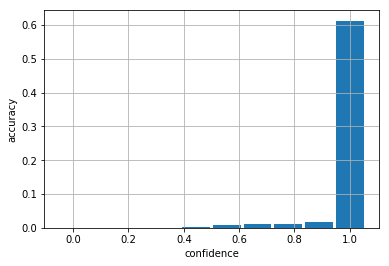

In [33]:
plot_discrepancy(lenet_predictions, y_test)

In [0]:
"""
Define a function that accepts predictions and ground truths, then plots the 
confidence vs. accuracy
"""
def plot_discrepancy(prediction, ground_truth):
    class_prediction = np.argmax(prediction, axis=1)
    class_confidence = np.max(prediction, axis=1)
    print("Min-max confidence: ", np.min(class_confidence), np.max(class_confidence))
    error = (class_prediction - ground_truth.flatten())
    # create 10 bins
    hist = []
    indicies_sum = 0
    for i in range(0,10):
        # indices for the max softmax that lies within certain range
        indices = np.argwhere((class_confidence >= (i*0.1)) &(class_confidence  <= (0.1*(i+1)))).flatten()
        indicies_sum += len(indices)
        correct_predictions = np.argwhere(np.argwhere(error[indices] == 0))
        hist.append(len(correct_predictions))
    print("check: ", np.sum(hist) / len(prediction))
    hist = np.array(hist) / len(prediction)
    plt.bar(np.linspace(0, 1, 10), hist, width=0.1)
    plt.grid()
    plt.xlabel('confidence')
    plt.ylabel('accuracy')

In [0]:
model = keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(32, 32, 3), classes=10)

In [0]:
output = model.output
pred = keras.layers.Flatten()(output)
pred = keras.layers.Dense(10, activation='softmax')(pred)

new_model = keras.models.Model(inputs=model.input, outputs=[pred])
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = new_model.fit(x_train, y_train, epochs=50)

In [57]:
score = new_model.evaluate(x_test, keras.utils.to_categorical(y_test))
print(score)

10000/10000 [==============================] - 3s 285us/step
[1.1007668595790863, 0.8072]


In [0]:
pred = new_model.predict(x_test)

In [19]:
print("Predictions shape: ", pred.shape)
print("softmax output for first test samples: \n", pred[0])

Predictions shape:  (10000, 10)
softmax output for first test samples: 
 [2.1020765e-06 5.7894169e-05 1.5895067e-06 9.9923861e-01 1.6379404e-08
 3.1021945e-04 6.8256741e-05 1.7916864e-05 1.9540475e-06 3.0148731e-04]


In [60]:
pred_idx = np.argmax(pred, axis=1)
max_conf = np.max(pred, axis=1)
print(pred_idx.shape, max_conf.shape)
print(np.min(max_conf), np.max(max_conf))

(10000,) (10000,)
0.24877599 1.0


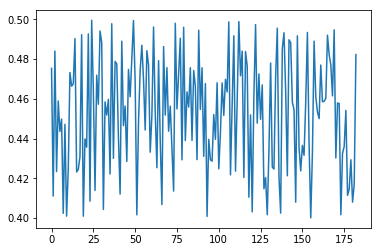

In [31]:
# check
plt.plot(max_pred[np.argwhere((max_pred > 0.4) &(max_pred  < 0.5))])

In [81]:
diff = pred_idx - y_test.flatten()
indices = np.argwhere((max_pred > (0.2)) &(max_pred  < (0.3))).flatten()
print(indices)
print(pred_idx[indices])
print(y_test.flatten()[indices])
print(diff[indices])
print(len(np.argwhere(diff[indices] == 0)))
print(len(np.argwhere(diff == 0)))

[ 366  376 1493 1736 2136 2232 2804 2840 3263 3391 3789 4190 5166 5517
 5869 6574 6729 6859 6904 6997 8006 9114]
[9 9 9 2 9 0 7 6 9 9 7 5 0 1 7 4 0 3 5 2 9 0]
[1 0 1 5 0 0 3 3 1 3 9 3 9 1 7 0 0 3 5 8 9 8]
[ 8  9  8 -3  9  0  4  3  8  6 -2  2 -9  0  0  4  0  0  0 -6  0 -8]
7
8072


In [92]:
# create 10 bins
hist = []
indicies_sum = 0
for i in range(0,10):
    print("Calculating predictions within confidence range {} - {}".format((i*0.1), ((i+1)*0.1)))
    # indices for the max softmax that lies within certain range
    indices = np.argwhere((max_pred >= (i*0.1)) &(max_pred  <= (0.1*(i+1)))).flatten()
    indicies_sum += len(indices)
    correct_predictions = np.argwhere(np.argwhere(diff[indices] == 0))
    print("Number of correct predictions for the specified confidence range", len(correct_predictions))
    hist.append(len(correct_predictions))

Calculating predictions within confidence range 0.0 - 0.1
Number of correct predictions for the specified confidence range 0
Calculating predictions within confidence range 0.1 - 0.2
Number of correct predictions for the specified confidence range 0
Calculating predictions within confidence range 0.2 - 0.30000000000000004
Number of correct predictions for the specified confidence range 7
Calculating predictions within confidence range 0.30000000000000004 - 0.4
Number of correct predictions for the specified confidence range 26
Calculating predictions within confidence range 0.4 - 0.5
Number of correct predictions for the specified confidence range 65
Calculating predictions within confidence range 0.5 - 0.6000000000000001
Number of correct predictions for the specified confidence range 98
Calculating predictions within confidence range 0.6000000000000001 - 0.7000000000000001
Number of correct predictions for the specified confidence range 140
Calculating predictions within confidence r

In [89]:
# Comparing the total number of correct predictions to the outcome of .evaluate
print(np.sum(hist) / y_test.shape[0])
print(score[1])

0.8068
0.8072


10 10


<BarContainer object of 10 artists>

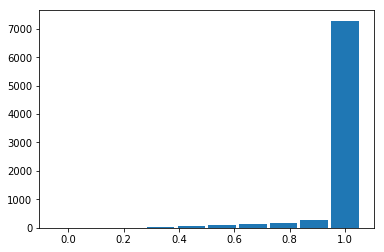

In [90]:
x = np.linspace(0, 1, 10)
print(len(x), len(hist))
plt.bar(x, hist, width=0.1)